## Setup & Imports

In [1]:
!pip install ipympl

In [2]:
# !pip install nibabel matplotlib

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
import torch
from scipy.ndimage import zoom
from tqdm import tqdm
import torch.nn.functional as F
from matplotlib.widgets import Slider
import plotly.graph_objects as go
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torch.optim import Adam
from concurrent.futures import ThreadPoolExecutor, as_completed

## Mount Google Drive

In [3]:
# # Mount Google Drive to access dataset files
# drive.mount('/content/drive')


## Load NIfTI Files

In [4]:
# Define data path and list NIfTI (.nii) files
data_path = "/kaggle/input/aims-tbs-challenge-files/ChallengeFiles"
file_list = sorted([f for f in os.listdir(data_path) if f.endswith('.nii')])

print(f"Found {len(file_list)} nii files")
print(file_list[:5])  # Show first 5 files


Found 1103 nii files
['scan_0001_Lesion.nii', 'scan_0001_T1.nii', 'scan_0004_Lesion.nii', 'scan_0004_T1.nii', 'scan_0007_Lesion.nii']


## Read Sample NIfTI File & Normalize

- .nii file are 3d images
- consider slices as the 2d images stacked together to create a 3d one

In [5]:
# Load a sample NIfTI file
nii_file = os.path.join(data_path, file_list[0])
img = nib.load(nii_file)
img_data = img.get_fdata()

print(f"Loaded file: {file_list[1]}")
print(f"Image shape: {img_data.shape}")

# Intensity normalization function for visualization
def normalize_slice(slice_data):
    slice_min = slice_data.min()
    slice_max = slice_data.max()
    if slice_max - slice_min > 0:
        return (slice_data - slice_min) / (slice_max - slice_min)
    else:
        return slice_data  # In case slice is constant


Loaded file: scan_0001_T1.nii
Image shape: (256, 256, 256)


### VIsualizing Slices

Medical image slices (like MRI or CT scans) are displayed in grayscale, where pixel values are mapped to shades from black (low intensity) to white (high intensity).

*   **Black Areas:** Typically represent regions with very low signal intensity. This includes the background (air), air-filled cavities, and certain tissue types depending on the scan method (e.g., bone or CSF in some MRI sequences, air in CT).
*   **White/Brighter Areas:** Represent regions with high signal intensity. This includes dense tissues (like bone in CT), certain tissue properties in MRI (like fat in T1-weighted or fluid/edema in T2-weighted), or areas with contrast agent uptake.

The contrast between dark and bright areas helps visualize

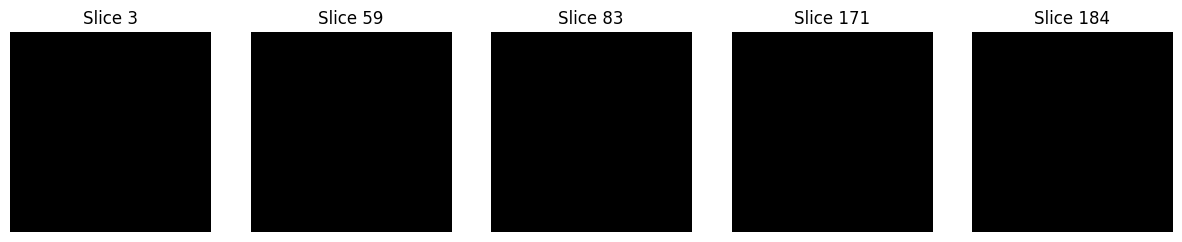

In [6]:
num_slices = 5
fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))

# Random unique slice indices from the axial dimension (depth)
slice_indices = np.random.choice(img_data.shape[2], size=num_slices, replace=False)
slice_indices = np.sort(slice_indices)  # optional: sort for nicer display order

for i, slice_idx in enumerate(slice_indices):
    slice_img = img_data[:, :, slice_idx].T
    norm_img = normalize_slice(slice_img)
    axes[i].imshow(norm_img, cmap='gray', origin='lower')
    axes[i].set_title(f"Slice {slice_idx}")
    axes[i].axis('off')

plt.show()

### Visualizing T1 Image with Lesion Mask

This code block loads both a T1-weighted MRI image and its corresponding lesion segmentation mask for the same scan. It then displays a series of slices from a specified range, overlaying the lesion mask on top of the T1 image to highlight the location and extent of the lesion.

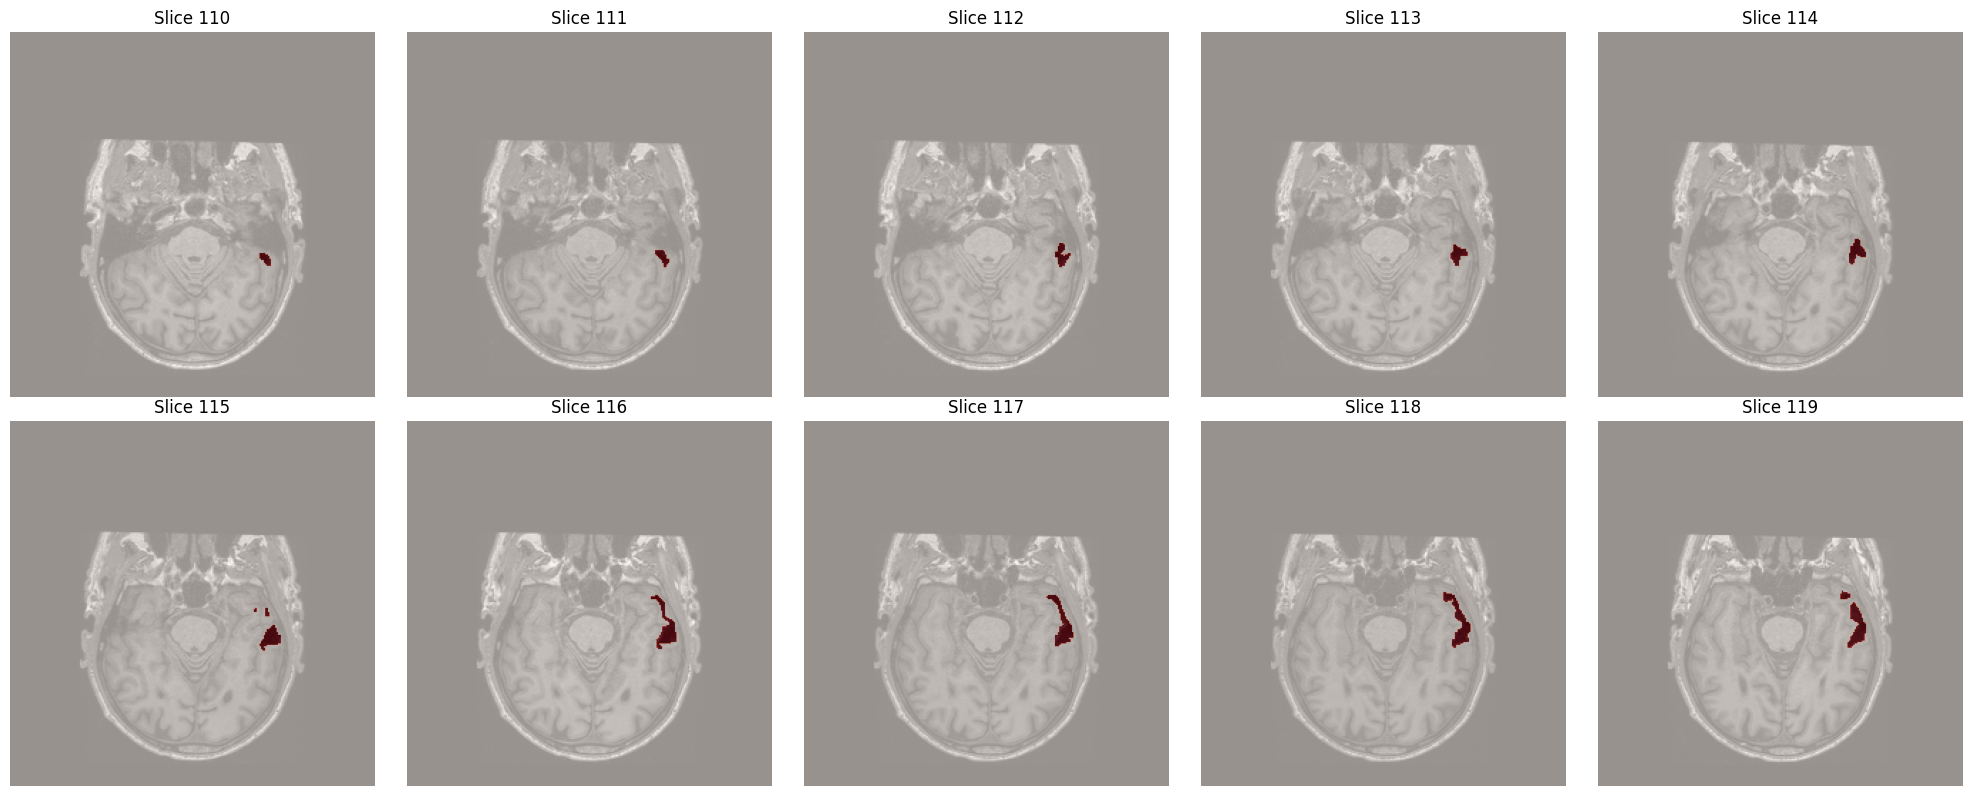

In [7]:
# Load both the T1 image and the Lesion mask
t1_file = os.path.join(data_path, 'scan_0001_T1.nii')
lesion_file = os.path.join(data_path, 'scan_0001_Lesion.nii')

t1_img = nib.load(t1_file).get_fdata()
lesion_img = nib.load(lesion_file).get_fdata()

# User-defined slice range
start_slice = 110
num_slices = 10

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(num_slices):
    slice_idx = start_slice + i
    t1_slice = t1_img[:, :, slice_idx].T
    lesion_slice = lesion_img[:, :, slice_idx].T

    axes[i].imshow(t1_slice, cmap='gray', origin='lower')
    axes[i].imshow(lesion_slice, cmap='Reds', alpha=0.6, origin='lower')
    axes[i].set_title(f"Slice {slice_idx}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Visualizing Coronal and Sagittal Slices

This code block demonstrates how to extract and visualize slices from the 3D image data (`img_data`) along planes other than the standard axial view. Specifically, it shows how to display a coronal slice and a sagittal slice from the middle of the image volume.

*   Medical 3D images can be viewed as stacks of 2D slices along different orientations:
    *   **Axial (or Transverse) slices:** Imagine slicing the body horizontally, like slicing a loaf of bread. These separate the top from the bottom.
    *   **Coronal slices:** Imagine slicing the body vertically from side-to-side, separating the front (anterior) from the back (posterior). This code visualizes a coronal slice.
    *   **Sagittal slices:** Imagine slicing the body vertically from front to back, separating the left side from the right side. This code visualizes a sagittal slice.

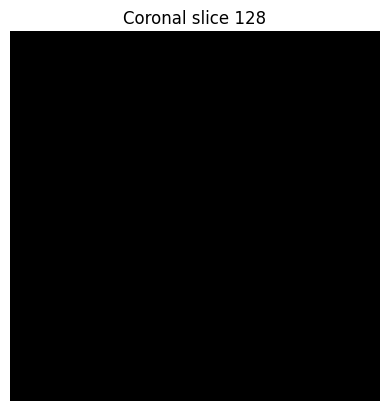

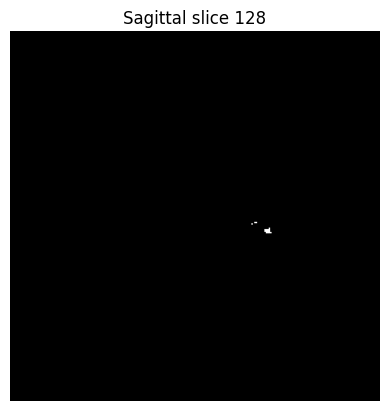

In [8]:
# Coronal slice (YZ plane)
slice_idx = img_data.shape[0] // 2
coronal_slice = normalize_slice(img_data[slice_idx, :, :].T)
plt.imshow(coronal_slice, cmap='gray', origin='lower')
plt.title(f"Coronal slice {slice_idx}")
plt.axis('off')
plt.show()

# Sagittal slice (XZ plane)
slice_idx = img_data.shape[1] // 2
sagittal_slice = normalize_slice(img_data[:, slice_idx, :].T)
plt.imshow(sagittal_slice, cmap='gray', origin='lower')
plt.title(f"Sagittal slice {slice_idx}")
plt.axis('off')
plt.show()


### Image Intensity Distribution and Non-Zero Voxels

- This code block analyzes the distribution of intensity values within the entire 3D image and calculates the proportion of voxels (3D pixels) that have non-zero intensity values.
- This helps understand the overall characteristics of the image data, such as the range of intensities present and how much of the image volume is not just background.

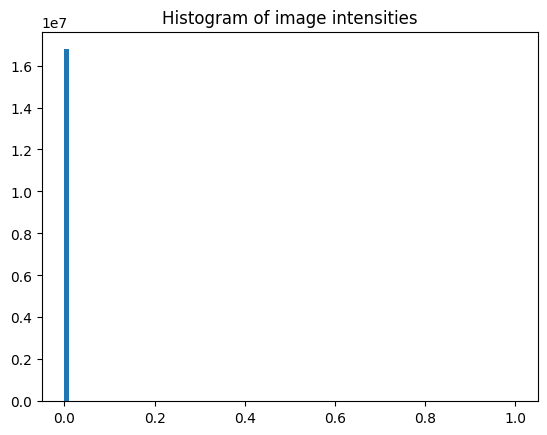

Non-zero voxels: 2150 / 16777216 (0.01%)


In [9]:
plt.hist(img_data.flatten(), bins=100)
plt.title("Histogram of image intensities")
plt.show()

nonzero_voxels = np.count_nonzero(img_data)
total_voxels = img_data.size
print(f"Non-zero voxels: {nonzero_voxels} / {total_voxels} ({100*nonzero_voxels/total_voxels:.2f}%)")


## Preprocessing pipeline

### Preprocessing Function

In [10]:
# def preprocess_scan(scan_path, mask_path=None, target_shape=(128, 128, 128), device='cuda'):
#     """
#     Preprocess T1 scan and mask using PyTorch (GPU-accelerated).

#     Loads and preprocesses a T1 MRI scan and optionally a lesion mask.

#     Args:
#         scan_path (str): Path to the T1-weighted MRI scan (.nii)
#         mask_path (str or None): Path to the lesion mask (.nii), if available
#         target_shape (tuple): Desired output shape for the scan/mask (D, H, W)
#         device (str): Device to perform computations on (e.g., 'cuda' or 'cpu')

#     Returns:
#         scan_tensor (torch.Tensor): Normalized and resampled scan tensor [1, D, H, W]
#         mask_tensor (torch.Tensor or None): Binarized and resampled mask tensor [1, D, H, W]
#         stats (dict): Dictionary with scan mean, std, and number of lesion voxels
#     """
#     # === Load scan as NumPy array using nibabel (CPU) ===
#     scan_np = nib.load(scan_path).get_fdata().astype(np.float32)  # Shape: [D, H, W]

#     # === Normalize scan to range [0, 1] ===
#     scan_np = (scan_np - scan_np.min()) / (scan_np.max() - scan_np.min() + 1e-5)

#     # === Convert scan to PyTorch tensor and move to GPU ===
#     # Add batch and channel dimensions: [1, 1, D, H, W]
#     scan_tensor = torch.tensor(scan_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

#     # === Resample (resize) scan tensor to target shape using trilinear interpolation ===
#     scan_tensor = F.interpolate(scan_tensor, size=target_shape, mode='trilinear', align_corners=False)

#     # Remove batch dimension: resulting shape [1, D, H, W]
#     scan_tensor = scan_tensor.squeeze(0)

#     # === Compute scan statistics ===
#     scan_mean = float(scan_tensor.mean())  # Global mean
#     scan_std = float(scan_tensor.std())    # Global standard deviation

#     # === Initialize outputs for lesion mask ===
#     mask_tensor = None
#     lesion_voxels = -1  # Default to -1 if no mask is provided

#     # === If mask path is provided, process the lesion mask ===
#     if mask_path:
#         # Load mask as NumPy array and binarize: values will be 0 or 1
#         mask_np = nib.load(mask_path).get_fdata().astype(np.uint8)
#         mask_np = (mask_np > 0).astype(np.float32)

#         # Convert to tensor, add batch/channel dims, and move to GPU
#         mask_tensor = torch.tensor(mask_np).unsqueeze(0).unsqueeze(0).to(device)

#         # Resample mask to target shape using nearest neighbor interpolation (preserves binary values)
#         mask_tensor = F.interpolate(mask_tensor, size=target_shape, mode='nearest')

#         # Remove batch dimension: resulting shape [1, D, H, W]
#         mask_tensor = mask_tensor.squeeze(0)

#         # Count number of lesion voxels (sum of binary mask)
#         lesion_voxels = int(mask_tensor.sum().item())

#     # === Collect scan statistics ===
#     stats = {
#         'scan_mean': scan_mean,
#         'scan_std': scan_std,
#         'lesion_voxels': lesion_voxels
#     }

#     return scan_tensor, mask_tensor, stats


### Process All Files & Detect Noisy Scans

In [11]:
raw_path = "/kaggle/input/aims-tbs-challenge-files/ChallengeFiles"
save_path = "/kaggle/input/aims-tbs-preprocessed-v1/PreprocessedData"

os.makedirs(save_path, exist_ok=True)

In [12]:
# # === Step 1: List and identify all scan IDs from the data path ===
# all_files = os.listdir(data_path)  # List all files in the dataset directory

# # Extract unique scan IDs by removing the suffix (_T1.nii), sort them alphabetically
# scan_ids = sorted(list(set('_'.join(f.split('_')[:-1]) for f in all_files if f.endswith("_T1.nii"))))

# # === Step 2: Set preprocessing parameters and initialize counters/trackers ===
# target_shape = (128, 128, 128)  # Desired 3D shape after resizing (D, H, W)

# skipped = 0     # Counter for scans that were already preprocessed
# processed = 0   # Counter for newly processed scans

# results = []        # List to store preprocessing statistics for all scans
# noisy_scans = []    # List to store IDs of scans considered noisy

# # === Step 3: Loop through each scan ID and preprocess it ===
# for scan_id in tqdm(scan_ids):  # tqdm shows a progress bar

#     # Build full paths to input scan and mask
#     t1_in = os.path.join(raw_path, f"{scan_id}_T1.nii")
#     lesion_in = os.path.join(raw_path, f"{scan_id}_Lesion.nii")

#     # Define output paths for saving preprocessed tensors
#     t1_out = os.path.join(save_path, f"{scan_id}_T1.pt")
#     lesion_out = os.path.join(save_path, f"{scan_id}_Lesion.pt")

#     # Skip if both output files already exist (already processed)
#     if os.path.exists(t1_out) and os.path.exists(lesion_out):
#         skipped += 1
#         continue

#     try:
#         # === Preprocess scan and mask using the defined function ===
#         scan_tensor, mask_tensor, stats = preprocess_scan(t1_in, lesion_in, target_shape)
#         stats["scan_id"] = scan_id  # Add scan ID to the stats

#         # === Check for potential noisy scans ===
#         # Criteria: very low mean, std, or no lesion voxels
#         if stats["scan_std"] < 0.01 or stats["scan_mean"] < 0.01 or stats["lesion_voxels"] == 0:
#             stats["noisy"] = True
#             noisy_scans.append(scan_id)  # Track noisy scan ID
#         else:
#             stats["noisy"] = False

#         # Store stats for the current scan
#         results.append(stats)

#         # === Save the preprocessed tensors to disk (on CPU) ===
#         torch.save(scan_tensor.cpu(), t1_out)
#         if mask_tensor is not None:
#             torch.save(mask_tensor.cpu(), lesion_out)

#         processed += 1  # Increment processed counter

#     except Exception as e:
#         # Catch and print any errors during preprocessing
#         print(f"❌ Error processing {scan_id}: {e}")


### View and Save Summary

In [13]:
# results_df = pd.DataFrame(results)
# results_df.sort_values("scan_std", ascending=True).head(10)

### Show Noisy Scan IDs

In [14]:
# print(f"⚠️ Total noisy scans detected: {len(noisy_scans)}\n")
# print("Some examples:")
# print(noisy_scans[:10])

## Import the preprocessed data

### Extract scan IDs from challenge files folder

In [15]:

all_files = os.listdir(raw_path)
scan_ids = sorted(list(set('_'.join(f.split('_')[:-1]) for f in all_files if f.endswith("_T1.nii"))))

print(f"Found {len(scan_ids)} scan IDs.")

Found 551 scan IDs.


### Function to load preprocessed tensors for a scan ID

In [16]:
def load_preprocessed(scan_id):
    t1_path = os.path.join(save_path, f"{scan_id}_T1.pt")
    lesion_path = os.path.join(save_path, f"{scan_id}_Lesion.pt")

    scan_tensor = None
    lesion_tensor = None

    if os.path.exists(t1_path):
        scan_tensor = torch.load(t1_path)
    else:
        print(f"Warning: Preprocessed T1 scan not found for {scan_id}")

    if os.path.exists(lesion_path):
        lesion_tensor = torch.load(lesion_path)

    return scan_tensor, lesion_tensor

### Load the preprocessed data

In [17]:
def load_single(scan_id):
    return scan_id, load_preprocessed(scan_id)

all_preprocessed_data = {}

with ThreadPoolExecutor(max_workers=2) as executor:
    futures = [executor.submit(load_single, sid) for sid in scan_ids]
    for future in tqdm(as_completed(futures), total=len(futures)):
        scan_id, (scan_tensor, lesion_tensor) = future.result()
        if scan_tensor is not None:
            all_preprocessed_data[scan_id] = {
                "scan": scan_tensor,
                "lesion": lesion_tensor
            }

100%|██████████| 551/551 [00:26<00:00, 20.57it/s]


### Visualize the processed scans

In [18]:

def show_multiple_slices(scan_tensor, lesion_tensor=None, axis=0, start_idx=0, num_slices=20):
    scan_np = scan_tensor.squeeze().cpu().numpy()
    if lesion_tensor is not None:
        lesion_np = lesion_tensor.squeeze().cpu().numpy()

    max_idx = scan_np.shape[axis] - 1
    end_idx = min(start_idx + num_slices, max_idx + 1)  # +1 because slicing is exclusive

    slices_to_show = end_idx - start_idx
    cols = 5  # Number of columns in the grid
    rows = (slices_to_show + cols - 1) // cols  # Compute rows needed

    plt.figure(figsize=(cols * 3, rows * 3))

    for i, slice_idx in enumerate(range(start_idx, end_idx)):
        plt.subplot(rows, cols, i + 1)
        if axis == 0:
            scan_slice = scan_np[slice_idx, :, :]
            lesion_slice = lesion_np[slice_idx, :, :] if lesion_tensor is not None else None
        elif axis == 1:
            scan_slice = scan_np[:, slice_idx, :]
            lesion_slice = lesion_np[:, slice_idx, :] if lesion_tensor is not None else None
        elif axis == 2:
            scan_slice = scan_np[:, :, slice_idx]
            lesion_slice = lesion_np[:, :, slice_idx] if lesion_tensor is not None else None
        else:
            raise ValueError("Axis must be 0, 1, or 2")

        plt.imshow(scan_slice, cmap='gray')
        if lesion_tensor is not None:
            plt.imshow(lesion_slice, cmap='Reds', alpha=0.4)
        plt.title(f"Slice {slice_idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


torch.Size([1, 128, 128, 128])


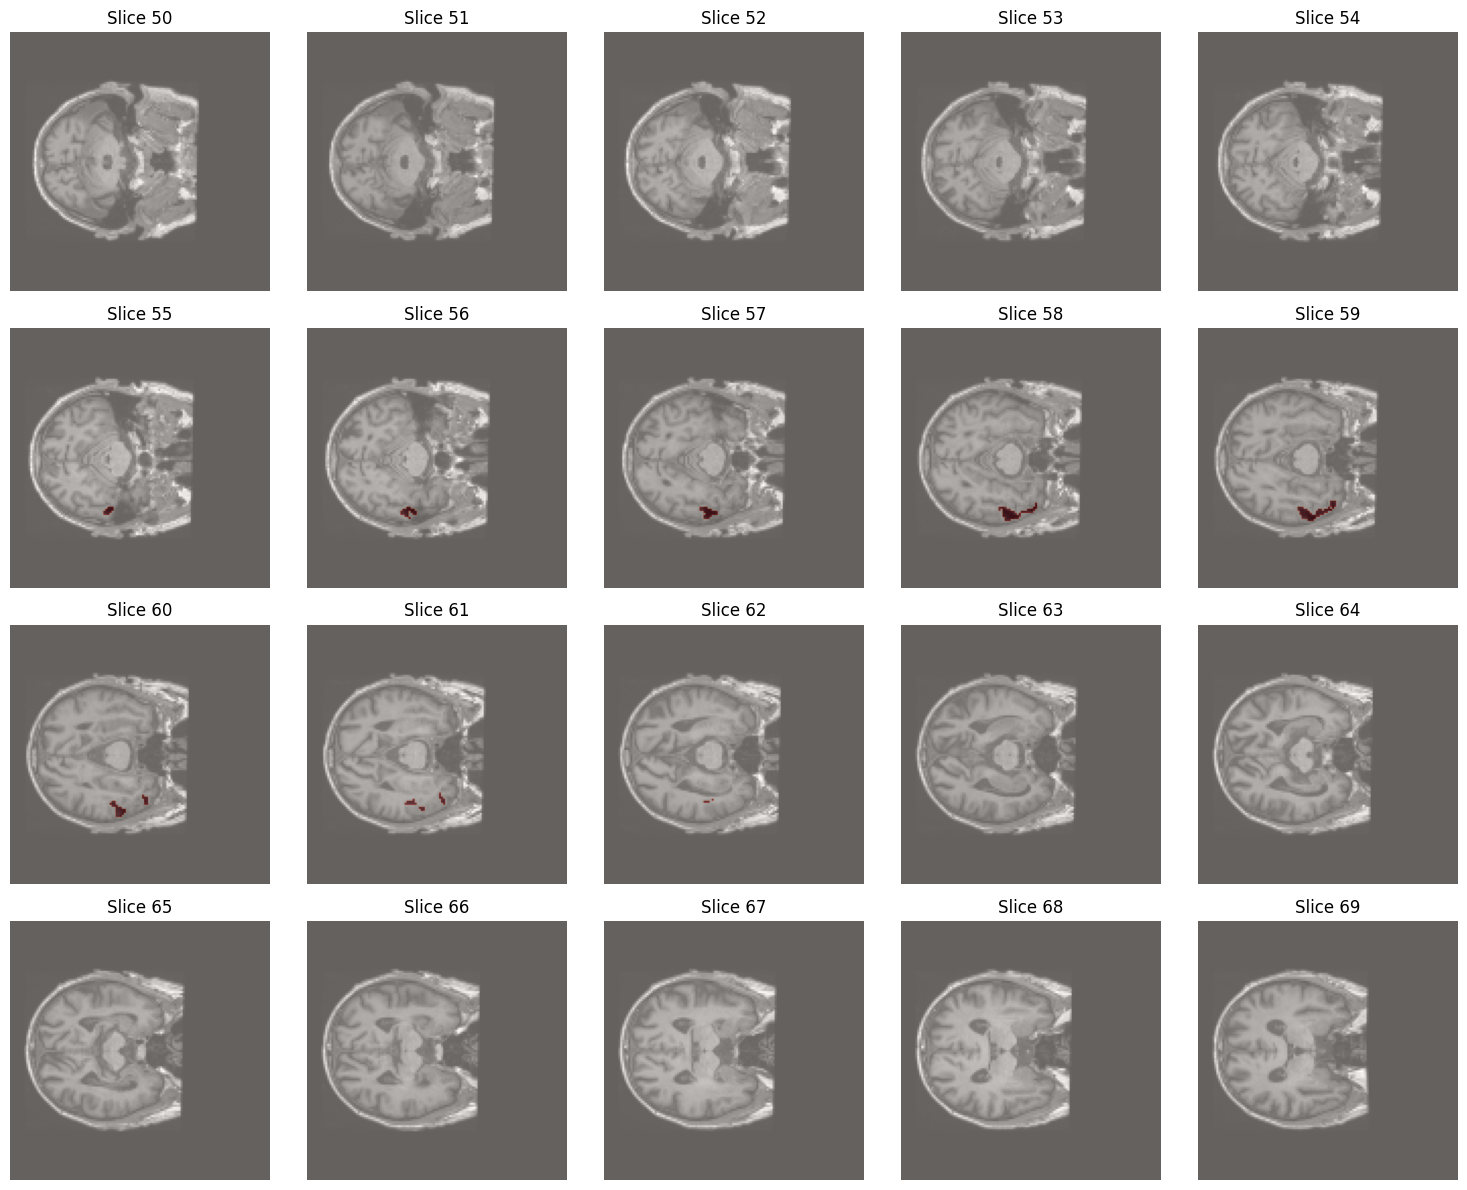

In [19]:
# Example: show one preprocessed scan with lesion
scan_id = list(all_preprocessed_data.keys())[0]
scan_tensor = all_preprocessed_data[scan_id]["scan"]
lesion_tensor = all_preprocessed_data[scan_id]["lesion"]

print(scan_tensor.shape)  # should be [1, D, H, W]


show_multiple_slices(scan_tensor, lesion_tensor, axis=2, start_idx=50)



### Visualize 3d lesions

In [20]:


def plot_3d_lesion(scan_tensor, lesion_tensor, threshold=0.5):
    scan_np = scan_tensor.squeeze().cpu().numpy()
    lesion_np = lesion_tensor.squeeze().cpu().numpy()

    # Create an isosurface for the lesion mask
    fig = go.Figure()

    # Lesion isosurface
    # fig.add_trace(go.Isosurface(
    #     x=np.arange(lesion_np.shape[0]),
    #     y=np.arange(lesion_np.shape[1]),
    #     z=np.arange(lesion_np.shape[2]),
    #     value=lesion_np,
    #     isomin=0.01,
    #     isomax=1,
    #     surface_count=1,
    #     colorscale='Reds',
    #     opacity=0.9,
    #     caps=dict(x_show=False, y_show=False, z_show=False),
    #     name='Lesion'
    # ))

    # Optionally, add scan volume (e.g. low opacity)
    fig.add_trace(go.Volume(
        x=np.arange(lesion_np.shape[0]),
        y=np.arange(lesion_np.shape[1]),
        z=np.arange(lesion_np.shape[2]),
        value=lesion_np,
        opacity=0.5,        # Adjust for visibility
        surface_count=15,   # Number of isosurfaces inside the volume
        colorscale='Reds',
        name='Lesion Volume'
    ))

    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'),
        title="3D Lesion Visualization"
    )
    fig.show()


In [21]:
# scan_id = list(all_preprocessed_data.keys())[0]
# scan_tensor = all_preprocessed_data[scan_id]["scan"]
# lesion_tensor = all_preprocessed_data[scan_id]["lesion"]

# # Convert tensors to numpy for inspection
# scan_np = scan_tensor.squeeze().cpu().numpy()
# lesion_np = lesion_tensor.squeeze().cpu().numpy()

# print("Scan shape:", scan_np.shape, "Min:", scan_np.min(), "Max:", scan_np.max())
# print("Lesion shape:", lesion_np.shape, "Min:", lesion_np.min(), "Max:", lesion_np.max())

# print("Lesion voxel count:", (lesion_np > 0.1).sum())

# plot_3d_lesion(scan_tensor, lesion_tensor)


## Training the model

### Defining the class for creating Pytorch Dataset

In [22]:
class TBI3DSegmentationDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.ids = list(data_dict.keys())
        self.data = data_dict
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        scan_id = self.ids[idx]
        scan = self.data[scan_id]["scan"]
        lesion = self.data[scan_id]["lesion"]

        # Ensure shape is (C, D, H, W)
        scan = scan.squeeze()  # remove extra dims if any
        lesion = lesion.squeeze()

        scan = scan.unsqueeze(0)
        lesion = lesion.unsqueeze(0)

        if self.transform:
            scan, lesion = self.transform(scan, lesion)

        return scan, lesion



### Split Train/Val + Create Loaders

In [23]:
full_dataset = TBI3DSegmentationDataset(all_preprocessed_data)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=2)

### 3DUNET Class

In [24]:
class DoubleConv3D(nn.Module):
    """(Conv3D => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]):
        super().__init__()

        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Down path
        for feature in features:
            self.encoder.append(DoubleConv3D(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv3D(features[-1], features[-1]*2)

        # Up path
        self.up_transpose = nn.ModuleList()
        self.decoder = nn.ModuleList()
        reversed_features = features[::-1]

        for feature in reversed_features:
            self.up_transpose.append(
                nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(
                DoubleConv3D(feature*2, feature)
            )

        # Final layer
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Downsampling
        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Upsampling
        for i in range(len(self.up_transpose)):
            x = self.up_transpose[i](x)
            skip = skip_connections[i]

            if x.shape != skip.shape:
                # Ensure spatial alignment
                x = F.interpolate(x, size=skip.shape[2:])

            x = torch.cat((skip, x), dim=1)
            x = self.decoder[i](x)

        return self.final_conv(x)  # logits, use with BCEWithLogitsLoss or sigmoid

### Initialize Model, Loss, Optimizer, Metrics

In [25]:
class SoftDiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        intersection = (preds * targets).sum()
        union = preds.sum() + targets.sum()
        dice = (2. * intersection + self.eps) / (union + self.eps)
        return 1 - dice


In [26]:
# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = UNet3D(in_channels=1, out_channels=1).to(device)

# Loss: recommended for binary segmentation with raw logits
bce = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(5.0, device=device))
dice = SoftDiceLoss()
criterion = lambda pred, target: 0.5 * bce(pred, target) + 0.5 * dice(pred, target)

# Optimizer
optimizer = Adam(model.parameters(), lr=1e-4)


### Define Dice Coefficient

In [27]:
def dice_coefficient(preds, targets, threshold=0.5, eps=1e-6):
    with torch.no_grad():
        preds = torch.sigmoid(preds)
        preds = (preds > threshold).float()

        intersection = (preds * targets).sum(dim=(1, 2, 3, 4))
        union = preds.sum(dim=(1, 2, 3, 4)) + targets.sum(dim=(1, 2, 3, 4))

        dice = (2. * intersection + eps) / (union + eps)
        return dice.mean().item()


### Training + Validation Loop

In [28]:
# data_path = "/content/drive/My Drive/AIMS - TBI Lesion Segmentation/"
# model_path = os.path.join(data_path, "best_3dunet_v2_epoch_20.pt")

In [29]:
# best_dice = 0.0
# trigger_times = 0
# patience = 10
# num_epochs = 20

# train_loss_list = []
# val_loss_list = []
# train_dice_list = []
# val_dice_list = []

# # Learning rate scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0.0
#     total_dice = 0.0

#     for scans, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
#         scans, masks = scans.to(device), masks.to(device)

#         outputs = model(scans)
#         loss = criterion(outputs, masks)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         total_dice += dice_coefficient(outputs, masks)

#     avg_train_loss = total_loss / len(train_loader)
#     avg_train_dice = total_dice / len(train_loader)
#     train_loss_list.append(avg_train_loss)
#     train_dice_list.append(avg_train_dice)

#     # Validation
#     model.eval()
#     val_loss = 0.0
#     val_dice = 0.0

#     with torch.no_grad():
#         for scans, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
#             scans, masks = scans.to(device), masks.to(device)

#             outputs = model(scans)
#             loss = criterion(outputs, masks)

#             val_loss += loss.item()
#             val_dice += dice_coefficient(outputs, masks)

#     avg_val_loss = val_loss / len(val_loader)
#     avg_val_dice = val_dice / len(val_loader)
#     val_loss_list.append(avg_val_loss)
#     val_dice_list.append(avg_val_dice)

#     # Scheduler step
#     scheduler.step(avg_val_dice)

#     # Logging
#     print(f"\n📊 Epoch {epoch+1}/{num_epochs} Summary:")
#     print(f"Train Loss: {avg_train_loss:.4f} | Dice: {avg_train_dice:.4f}")
#     print(f"Val   Loss: {avg_val_loss:.4f} | Dice: {avg_val_dice:.4f}")

#     # Save best model
#     if avg_val_dice > best_dice:
#         best_dice = avg_val_dice
#         torch.save(model.state_dict(), model_path)
#         print(f"✅ Saved best model at epoch {epoch+1} with Dice: {best_dice:.4f}")
#         trigger_times = 0

#         # Save training stats
#         stats_path = model_path.replace('.pt', '.txt')
#         with open(stats_path, 'w') as f:
#             f.write(f"Best Epoch: {epoch+1}\n")
#             f.write(f"Best Val Dice: {best_dice:.4f}\n\n")
#             f.write("Epoch\tTrain Loss\tVal Loss\tTrain Dice\tVal Dice\n")
#             for i in range(epoch + 1):
#                 f.write(f"{i+1}\t{train_loss_list[i]:.4f}\t{val_loss_list[i]:.4f}\t"
#                         f"{train_dice_list[i]:.4f}\t{val_dice_list[i]:.4f}\n")

#     else:
#         trigger_times += 1
#         print(f"⚠️ No improvement. Patience counter: {trigger_times}/{patience}")

#         if trigger_times >= patience:
#             print("🛑 Early stopping triggered.")
#             break


### Import the model from drive

In [30]:
# model = UNet3D(in_channels=1, out_channels=1)
# model.load_state_dict(torch.load(model_path))
# model.to(device)
# model.eval()